In [ ]:
!pip install --upgrade pip setuptools wheel
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg
!pip install geopandas

In [ ]:
import numpy as np
import pandas as pd
# import geopandas as gpd
import matplotlib.pyplot as plt 
import json
%pylab inline 
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


## Travel Count before COVID

Estimated Count = Visitor Count * Population / Device Count

Groupby CBG: Mean Weekly Estimated Count of POIs

In [ ]:
trips = pd.read_csv('/content/drive/MyDrive/SafeGraph/Data/weekly_trips_20211017.csv')
trips.date_range_start = pd.to_datetime(trips.date_range_start, utc=True)
# filter data in 2019
trips = trips[(trips.date_range_start>=pd.to_datetime('2019-01-01 00:00:00-00:00', utc=True))&(trips.date_range_start<pd.to_datetime('2020-01-01 00:00:00-00:00', utc=True))]
trips.head()

In [ ]:
trips.to_csv('/content/drive/MyDrive/SafeGraph/Data/trips_2019.csv', index=False)

In [ ]:
trips = pd.read_csv('/content/drive/MyDrive/SafeGraph/Data/trips_2019.csv')
trips.head()

In [ ]:
# median values in time
travel = trips[['visitor_home_cbg_id', 'date_range_start', 'esimated_visitor_count']].groupby(['visitor_home_cbg_id', 'date_range_start'], as_index=False).median()
# median values in each cbg
travel = travel.groupby('visitor_home_cbg_id', as_index=False).median()
travel.head()

In [ ]:
travel.shape

(6338, 2)

In [ ]:
travel.to_csv('/content/drive/MyDrive/SafeGraph/Data/cbg_estimated_count_2019.csv', index=False)

## Census Data Processing

https://www.census.gov/programs-surveys/acs/guidance/which-data-tool/table-ids-explained.html

https://docs.safegraph.com/docs/open-census-data

**01 Population; Age; Sex**

**02 Race** （Latinxs were 1.6 times more likely than whites to report their food access diminished by “a lot.” Asian respondents also reported significantly reduced ability to get food, with 54.8% reporting reduced access by “a lot” or “somewhat.” ）

05
Citizenship Status; Year of Entry; Foreign Born Place of Birth

07
Migration/Residence 1 Year Ago

08
Place of Work

**11 Household Type**

12
Marital Status; Marital History

14
School Enrollment

**15 Educational Attainment**

16
Language Spoken at Home

**17 Poverty Status**

**19 Income** (Consumption level)

**22 Food Stamps/Supplemental Nutrition Assistance Program (SNAP)**

**23 Employment Status; Work Status Last Year** (Current consumption & future expectations)

27
Health Insurance Coverage

*Median dollar value of owner occupied housing units

*Median rent of renter occupied housing units

In [ ]:
census_des = pd.read_csv('/content/drive/MyDrive/SafeGraph/SafeGraph Open Census Data/safegraph_open_census_data_2019/metadata/cbg_field_descriptions.csv') 
census_des.shape

(8120, 15)

In [ ]:
def generate_field_dict(df):
    
    NAME = []
    ID = []
    for i in df.index:
        if str(df.field_level_6[i]) != 'nan':
            NAME.append(df.field_level_6[i])
            ID.append(df.table_id[i])
        elif str(df.field_level_5[i]) != 'nan':
            NAME.append(df.field_level_5[i])
            ID.append(df.table_id[i])
        else:
            NAME.append(df.field_level_3[i])
            ID.append(df.table_id[i])

    field_dict = dict(zip(ID,NAME))
    return field_dict

In [ ]:
def extract_data_columns(field_dict, file_num):
    
    file_path = '/content/drive/MyDrive/SafeGraph/SafeGraph Open Census Data/safegraph_open_census_data_2019/data/cbg_' + file_num + '.csv'
    df = pd.read_csv(file_path)
    df_col = df[['census_block_group'] + list(field_dict.keys())].rename(columns=field_dict).set_index('census_block_group')
    return df_col

In [ ]:
def num_to_percent(df, denominator, column_list):
    
    RENAME = {}
    for c in column_list:
        df[c] = df[c] / df[denominator]
        RENAME[c] = 'Percent ' + c
    df = df.rename(columns=RENAME)

    return df

In [ ]:
# 01 pop, age, gender
census_des[(census_des.table_number.isin(['B01001', 'B01002']))&(census_des.field_level_1=='Estimate')&(census_des.field_level_6.isnull())] 

,table_id,table_number,table_title,table_topics,table_universe,field_level_1,field_level_2,field_level_3,field_level_4,field_level_5,field_level_6,field_level_7,field_level_8,field_level_9,field_level_10
0,B01001e1,B01001,Sex By Age,Age and Sex,Total population,Estimate,SEX BY AGE,Total population,Total,NaN,NaN,NaN,NaN,NaN,NaN
11,B01001e2,B01001,Sex By Age,Age and Sex,Total population,Estimate,SEX BY AGE,Total population,Total,Male,NaN,NaN,NaN,NaN,NaN
18,B01001e26,B01001,Sex By Age,Age and Sex,Total population,Estimate,SEX BY AGE,Total population,Total,Female,NaN,NaN,NaN,NaN,NaN
122,B01002e1,B01002,Median Age By Sex,Age and Sex,Total population,Estimate,MEDIAN AGE BY SEX,Total population,Median age,Total,NaN,NaN,NaN,NaN,NaN
123,B01002e2,B01002,Median Age By Sex,Age and Sex,Total population,Estimate,MEDIAN AGE BY SEX,Total population,Median age,Male,NaN,NaN,NaN,NaN,NaN
124,B01002e3,B01002,Median Age By Sex,Age and Sex,Total population,Estimate,MEDIAN AGE BY SEX,Total population,Median age,Female,NaN,NaN,NaN,NaN,NaN


In [ ]:
pop_dict = {'B01001e1': 'Total Population',
            'B01001e2': 'Male',
            'B01002e1': 'Median Age'} # 'B01001e26': 'Female',
pop = extract_data_columns(pop_dict, 'b01')
# pop['Gender Ratio'] = pop['Male'] / pop['Female'] # lots of inf
pop = num_to_percent(pop, 'Total Population', ['Male'])
pop.head()

,Total Population,Percent Male,Median Age
census_block_group,,,
10010201001,730,0.401370,43.3
10010201002,1263,0.486144,38.2
10010202001,835,0.470659,38.7
10010202002,1124,0.591637,42.9
10010203001,2774,0.512978,37.3


In [ ]:
# 02 Race 
race_des = census_des[census_des.table_number.isin(['B02%s' % str(i).zfill(3) for i in range(1, 14)])&
           (census_des.field_level_1=='Estimate')&
           (census_des.table_title=='Race')]
generate_field_dict(race_des)

{'B02001e1': 'Total population',
 'B02001e10': 'Two races excluding Some other race and three or more races',
 'B02001e2': 'White alone',
 'B02001e3': 'Black or African American alone',
 'B02001e4': 'American Indian and Alaska Native alone',
 'B02001e5': 'Asian alone',
 'B02001e6': 'Native Hawaiian and Other Pacific Islander alone',
 'B02001e7': 'Some other race alone',
 'B02001e8': 'Two or more races',
 'B02001e9': 'Two races including Some other race'}

In [ ]:
race_dict = generate_field_dict(race_des)
race = extract_data_columns(race_dict, 'b02')
# merge Asian Alone & Two races including Some other race
race['Asian alone & Two races including Some other race'] = race['Asian alone'] + race['Two races including Some other race']
race = race.drop(['Asian alone', 'Two races including Some other race'], axis=1)
race = num_to_percent(race, 'Total population', race.columns[1:])
race = race.iloc[:, 1:]
race.head()

,Percent Two races excluding Some other race and three or more races,Percent White alone,Percent Black or African American alone,Percent American Indian and Alaska Native alone,Percent Native Hawaiian and Other Pacific Islander alone,Percent Some other race alone,Percent Two or more races,Percent Asian alone & Two races including Some other race
census_block_group,,,,,,,,
10010201001,0.078082,0.839726,0.082192,0.0,0.000000,0.000000,0.078082,0.000000
10010201002,0.076801,0.848773,0.072842,0.0,0.000000,0.000000,0.076801,0.001584
10010202001,0.037126,0.330539,0.607186,0.0,0.025150,0.000000,0.037126,0.000000
10010202002,0.022242,0.429715,0.542705,0.0,0.000000,0.005338,0.022242,0.000000
10010203001,0.029200,0.672675,0.200793,0.0,0.001802,0.083994,0.029200,0.011536


In [ ]:
# 11 Household Type
B11 = ['B11005', 'B11006', 'B11007'] # family type & children 'B11003'
household_des = census_des[census_des.table_number.isin(B11)&
           (census_des.field_level_1=='Estimate')&
           (census_des.field_level_6.isnull())&
           (census_des.field_level_5.notnull())]
generate_field_dict(household_des)

{'B11005e11': 'Households with no people under 18 years',
 'B11005e2': 'Households with one or more people under 18 years',
 'B11006e2': 'Households with one or more people 60 years and over',
 'B11006e9': 'Households with no people 60 years and over',
 'B11007e2': 'Households with one or more people 65 years and over',
 'B11007e7': 'Households with no people 65 years and over'}

In [ ]:
household_dict = generate_field_dict(household_des)
household_dict['B11005e1'] = 'Total Households'
household = extract_data_columns(household_dict, 'b11')
household = num_to_percent(household, 'Total Households', household.columns[:-1])
household = household[['Total Households',
                       'Percent Households with one or more people under 18 years', 
                       'Percent Households with one or more people 60 years and over']]
household.head()

,Total Households,Percent Households with one or more people under 18 years,Percent Households with one or more people 60 years and over
census_block_group,,,
10010201001,315,0.285714,0.425397
10010201002,394,0.385787,0.276650
10010202001,318,0.402516,0.490566
10010202002,370,0.170270,0.335135
10010203001,1026,0.416179,0.334308


In [ ]:
# 15 Educational Attainment
B15 = ['B15003', 'B15011']
edu_des = census_des[census_des.table_number.isin(B15)&
           (census_des.field_level_1=='Estimate')&
           (census_des.field_level_6.isnull())]
generate_field_dict(edu_des)

{'B15003e1': 'Population 25 years and over',
 'B15003e10': '6th grade',
 'B15003e11': '7th grade',
 'B15003e12': '8th grade',
 'B15003e13': '9th grade',
 'B15003e14': '10th grade',
 'B15003e15': '11th grade',
 'B15003e16': '12th grade no diploma',
 'B15003e17': 'Regular high school diploma',
 'B15003e18': 'GED or alternative credential',
 'B15003e19': 'Some college less than 1 year',
 'B15003e2': 'No schooling completed',
 'B15003e20': 'Some college 1 or more years no degree',
 'B15003e21': "Associate's degree",
 'B15003e22': "Bachelor's degree",
 'B15003e23': "Master's degree",
 'B15003e24': 'Professional school degree',
 'B15003e25': 'Doctorate degree',
 'B15003e3': 'Nursery school',
 'B15003e4': 'Kindergarten',
 'B15003e5': '1st grade',
 'B15003e6': '2nd grade',
 'B15003e7': '3rd grade',
 'B15003e8': '4th grade',
 'B15003e9': '5th grade',
 'B15011e1': "POPULATION 25 YEARS AND OVER WITH A BACHELOR'S DEGREE OR HIGHER ATTAINMENT",
 'B15011e2': 'Male',
 'B15011e21': 'Female'}

In [ ]:
# Percent over 25 without a high school diploma
edu_dict = generate_field_dict(edu_des)
edu = extract_data_columns(edu_dict, 'b15')
edu.head()

UnderHighSchool = ['6th grade', '7th grade', '8th grade',
                  '9th grade', '10th grade', '11th grade', '12th grade no diploma', 
                  'No schooling completed', '1st grade',
                  '2nd grade', '3rd grade', '4th grade', '5th grade',]
edu['Percent over 25 without a high school diploma'] = edu[UnderHighSchool].sum(axis=1) / edu['Population 25 years and over']
edu['Percent over 25 with a bachelor’s degree or higher'] = edu["POPULATION 25 YEARS AND OVER WITH A BACHELOR'S DEGREE OR HIGHER ATTAINMENT"] / edu['Population 25 years and over']
edu = edu[['Percent over 25 without a high school diploma', 'Percent over 25 with a bachelor’s degree or higher']]
edu.head()

,Percent over 25 without a high school diploma,Percent over 25 with a bachelor’s degree or higher
census_block_group,,
10010201001,0.207843,0.178431
10010201002,0.073801,0.329643
10010202001,0.125230,0.095764
10010202002,0.162791,0.218605
10010203001,0.126368,0.196517


In [ ]:
# 17 Poverty Status

B17 = ['B17017', ] # 'C17002' age ratio 'B17021' pop 
poverty_des = census_des[census_des.table_number.isin(B17)&
           (census_des.field_level_1=='Estimate')&
           (census_des.field_level_6.isnull())]
generate_field_dict(poverty_des)

{'B17017e1': 'Households',
 'B17017e2': 'Income in the past 12 months below poverty level',
 'B17017e31': 'Income in the past 12 months at or above poverty level'}

In [ ]:
poverty_dict = generate_field_dict(poverty_des)
b17 = pd.read_csv('/content/drive/MyDrive/SafeGraph/SafeGraph Open Census Data/safegraph_open_census_data_2019/data/cbg_b17.csv')
poverty = b17[['census_block_group'] + list(poverty_dict.keys())].rename(columns=poverty_dict).set_index('census_block_group')
poverty = num_to_percent(poverty, 'Households', poverty.columns[1:])
poverty = poverty[['Percent Income in the past 12 months below poverty level']]
poverty.columns = ['Percent Households Income in the past 12 months below poverty level']
poverty.head()

,Percent Households Income in the past 12 months below poverty level
census_block_group,
10010201001,0.209524
10010201002,0.134518
10010202001,0.421384
10010202002,0.108108
10010203001,0.099415


In [ ]:
# 19 Income
census_des[(census_des.table_number == 'B19013')&(census_des.field_level_1=='Estimate')]
b19 = pd.read_csv('/content/drive/MyDrive/SafeGraph/SafeGraph Open Census Data/safegraph_open_census_data_2019/data/cbg_b19.csv')
income = b19[['census_block_group', 'B19013e1']].rename(columns={'B19013e1': 'Median Household Income'}).set_index('census_block_group')
income.head()

,Median Household Income
census_block_group,
10010201001,35703.0
10010201002,79000.0
10010202001,26500.0
10010202002,51042.0
10010203001,59048.0


In [ ]:
# 22 Food Stamps/Supplemental Nutrition Assistance Program (SNAP)
snap_des = census_des[census_des.table_number.isin(['B22%s' % str(i).zfill(3) for i in range(1, 20)])&
           (census_des.field_level_1=='Estimate')]
generate_field_dict(snap_des)

{'B22010e1': 'Households',
 'B22010e2': 'Household received Food Stamps/SNAP in the past 12 months',
 'B22010e3': 'Households with 1 or more persons with a disability',
 'B22010e4': 'Households with no persons with a disability',
 'B22010e5': 'Household did not receive Food Stamps/SNAP in the past 12 months',
 'B22010e6': 'Households with 1 or more persons with a disability',
 'B22010e7': 'Households with no persons with a disability'}

In [ ]:
snap_dict = {'B22010e1': 'Households',
             'B22010e2': 'Household received Food Stamps/SNAP',
             'B22010e3': 'Households received Food Stamps/SNAP have disability',
             'B22010e5': 'Household did not receive Food Stamps/SNAP',
             'B22010e6': 'Households did not received Food Stamps/SNAP with disability'}
b22 = pd.read_csv('/content/drive/MyDrive/SafeGraph/SafeGraph Open Census Data/safegraph_open_census_data_2019/data/cbg_b22.csv')
snap = b22[['census_block_group'] + list(snap_dict.keys())].rename(columns=snap_dict).set_index('census_block_group')
# snap['Percent Households with disability received Food Stamps/SNAP'] = snap.iloc[:, 2] / (snap.iloc[:, 2] + snap.iloc[:, 4])
snap = num_to_percent(snap, 'Households', snap.columns[1:5]).drop('Households', axis=1)
snap.iloc[:, 1] = snap.iloc[:, 1] / snap.iloc[:, 0]
snap = snap.drop(['Percent Household did not receive Food Stamps/SNAP', 
                  'Percent Households did not received Food Stamps/SNAP with disability'], axis=1)
snap.head()

,Percent Household received Food Stamps/SNAP,Percent Households received Food Stamps/SNAP have disability
census_block_group,,
10010201001,0.196825,0.516129
10010201002,0.157360,0.483871
10010202001,0.383648,0.196721
10010202002,0.140541,0.307692
10010203001,0.117934,0.793388


In [ ]:
# 23 Employment
# census_des.table_number.unique()
census_des[census_des.table_id.isin(['B23025e4', 'B23025e5', 'B23025e3'])]

,table_id,table_number,table_title,table_topics,table_universe,field_level_1,field_level_2,field_level_3,field_level_4,field_level_5,field_level_6,field_level_7,field_level_8,field_level_9,field_level_10
4164,B23025e3,B23025,Employment Status For The Population 16 Years ...,Employment and Labor Force Status,Population 16 years and over,Estimate,EMPLOYMENT STATUS FOR THE POPULATION 16 YEARS ...,Population 16 years and over,Total,In labor force,Civilian labor force,NaN,NaN,NaN,NaN
4165,B23025e4,B23025,Employment Status For The Population 16 Years ...,Employment and Labor Force Status,Population 16 years and over,Estimate,EMPLOYMENT STATUS FOR THE POPULATION 16 YEARS ...,Population 16 years and over,Total,In labor force,Civilian labor force,Employed,NaN,NaN,NaN
4166,B23025e5,B23025,Employment Status For The Population 16 Years ...,Employment and Labor Force Status,Population 16 years and over,Estimate,EMPLOYMENT STATUS FOR THE POPULATION 16 YEARS ...,Population 16 years and over,Total,In labor force,Civilian labor force,Unemployed,NaN,NaN,NaN


In [ ]:
c23 = pd.read_csv('/content/drive/MyDrive/SafeGraph/SafeGraph Open Census Data/safegraph_open_census_data_2019/data/cbg_b23.csv')
employment = c23[['census_block_group', 'B23025e4', 'B23025e3']].rename(
    columns={'B23025e4': 'Employed', 'B23025e3': 'Civilian labor force'}).set_index('census_block_group') # 'B23025e5', , 'B23025e5': 'Unemployed'
employment = num_to_percent(employment, 'Civilian labor force', ['Employed']) # , 'Unemployed'
employment.head()

,Percent Employed,Civilian labor force
census_block_group,,
10010201001,0.971875,320
10010201002,0.971212,660
10010202001,1.000000,253
10010202002,0.934394,503
10010203001,0.961640,1512


In [ ]:
# merge the demographic features 
census_df = pd.concat([pop, race, household, edu, poverty, income, snap, employment], axis=1)
cbg = gpd.read_file('/content/drive/MyDrive/SafeGraph/Data/nyc_cbgs.geojson')
census_df = census_df[census_df.index.isin(cbg.CensusBlockGroup)]#.fillna(0)
census_df = num_to_percent(census_df, 'Total Population', ['Civilian labor force'])
census_df.head()

,Total Population,Percent Male,Median Age,Percent Two races excluding Some other race and three or more races,Percent White alone,Percent Black or African American alone,Percent American Indian and Alaska Native alone,Percent Native Hawaiian and Other Pacific Islander alone,Percent Some other race alone,Percent Two or more races,Percent Asian alone & Two races including Some other race,Total Households,Percent Households with one or more people under 18 years,Percent Households with one or more people 60 years and over,Percent over 25 without a high school diploma,Percent over 25 with a bachelor’s degree or higher,Percent Households Income in the past 12 months below poverty level,Median Household Income,Percent Household received Food Stamps/SNAP,Percent Households received Food Stamps/SNAP have disability,Percent Employed,Percent Civilian labor force
census_block_group,,,,,,,,,,,,,,,,,,,,,,
360050001000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
360050001001,6864,0.924388,35.0,0.015006,0.325321,0.557110,0.002622,0.0,0.073572,0.015006,0.026369,0,NaN,NaN,0.515975,0.014873,NaN,NaN,NaN,NaN,NaN,0.000000
360050002000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
360050002001,1744,0.444381,40.2,0.014908,0.460436,0.331422,0.000000,0.0,0.193234,0.014908,0.000000,460,0.423913,0.541304,0.246892,0.277975,0.326087,41968.0,0.334783,0.357143,0.762500,0.366972
360050002002,1569,0.527725,28.9,0.013384,0.368388,0.291906,0.000000,0.0,0.281071,0.058636,0.045252,477,0.421384,0.425577,0.243154,0.303395,0.144654,48523.0,0.190776,0.637363,0.860104,0.369025


In [ ]:
census_df.shape

(6493, 22)

In [ ]:
census_df.to_csv('/content/drive/MyDrive/SafeGraph/Data/raw_cbg_attr.csv', index=True)

## Feature Engineering 

Merge the travel & census data

Train PCA and select tranformed data with lowest mean square error

In [ ]:
census = pd.read_csv('/content/drive/MyDrive/SafeGraph/Data/raw_cbg_attr.csv')
travel = pd.read_csv('/content/drive/MyDrive/SafeGraph/Data/cbg_estimated_count_2019.csv')
df = travel[['visitor_home_cbg_id',	'esimated_visitor_count']].merge(census, left_on='visitor_home_cbg_id', right_on='census_block_group', how='inner')
df = df.set_index('census_block_group').drop('visitor_home_cbg_id', axis=1).rename(columns={'esimated_visitor_count': 'Median Esimated Visitor Count'})
df = df[df['Total Population']>=10]
df.head()

,Median Esimated Visitor Count,Total Population,Percent Male,Median Age,Percent Two races excluding Some other race and three or more races,Percent White alone,Percent Black or African American alone,Percent American Indian and Alaska Native alone,Percent Native Hawaiian and Other Pacific Islander alone,Percent Some other race alone,Percent Two or more races,Percent Asian alone & Two races including Some other race,Total Households,Percent Households with one or more people under 18 years,Percent Households with one or more people 60 years and over,Percent over 25 without a high school diploma,Percent over 25 with a bachelor’s degree or higher,Percent Households Income in the past 12 months below poverty level,Median Household Income,Percent Household received Food Stamps/SNAP,Percent Households received Food Stamps/SNAP have disability,Percent Employed,Percent Civilian labor force
census_block_group,,,,,,,,,,,,,,,,,,,,,,,
360050001001,226.924590,6864,0.924388,35.0,0.015006,0.325321,0.557110,0.002622,0.0,0.073572,0.015006,0.026369,0,NaN,NaN,0.515975,0.014873,NaN,NaN,NaN,NaN,NaN,0.000000
360050002001,15.659303,1744,0.444381,40.2,0.014908,0.460436,0.331422,0.000000,0.0,0.193234,0.014908,0.000000,460,0.423913,0.541304,0.246892,0.277975,0.326087,41968.0,0.334783,0.357143,0.762500,0.366972
360050002002,7.781848,1569,0.527725,28.9,0.013384,0.368388,0.291906,0.000000,0.0,0.281071,0.058636,0.045252,477,0.421384,0.425577,0.243154,0.303395,0.144654,48523.0,0.190776,0.637363,0.860104,0.369025
360050002003,9.376958,1219,0.484003,42.2,0.043478,0.441345,0.274815,0.000000,0.0,0.178835,0.043478,0.061526,405,0.407407,0.585185,0.137892,0.306054,0.024691,68060.0,0.108642,1.000000,0.985940,0.466776
360050004001,6.738028,598,0.548495,40.3,0.000000,0.707358,0.065217,0.000000,0.0,0.215719,0.000000,0.011706,262,0.213740,0.492366,0.174731,0.206989,0.312977,NaN,0.095420,0.000000,1.000000,0.605351


In [ ]:
df.shape

(6221, 23)

In [ ]:
df.to_csv('/content/drive/MyDrive/SafeGraph/Data/cbg_attr_with_travel.csv', index=True)

In [ ]:
features = df.drop(['Total Population', 'Total Households'], axis=1).fillna(0)
features.head()

,Median Esimated Visitor Count,Percent Male,Median Age,Percent Two races excluding Some other race and three or more races,Percent White alone,Percent Black or African American alone,Percent American Indian and Alaska Native alone,Percent Native Hawaiian and Other Pacific Islander alone,Percent Some other race alone,Percent Two or more races,Percent Asian alone & Two races including Some other race,Percent Households with one or more people under 18 years,Percent Households with one or more people 60 years and over,Percent over 25 without a high school diploma,Percent over 25 with a bachelor’s degree or higher,Percent Households Income in the past 12 months below poverty level,Median Household Income,Percent Household received Food Stamps/SNAP,Percent Households received Food Stamps/SNAP have disability,Percent Employed,Percent Civilian labor force
census_block_group,,,,,,,,,,,,,,,,,,,,,
360050001001,0.818649,0.924388,0.335451,0.015006,0.325321,0.557110,0.002622,0.0,0.073572,0.015006,0.026369,0.000000,0.000000,0.515975,0.014873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
360050002001,0.056457,0.444381,0.401525,0.014908,0.460436,0.331422,0.000000,0.0,0.193234,0.014908,0.000000,0.423913,0.541304,0.246892,0.277975,0.326087,0.138608,0.334783,0.357143,0.762500,0.366972
360050002002,0.028038,0.527725,0.257942,0.013384,0.368388,0.291906,0.000000,0.0,0.281071,0.058636,0.045252,0.421384,0.425577,0.243154,0.303395,0.144654,0.165750,0.190776,0.637363,0.860104,0.369025
360050002003,0.033792,0.484003,0.426938,0.043478,0.441345,0.274815,0.000000,0.0,0.178835,0.043478,0.061526,0.407407,0.585185,0.137892,0.306054,0.024691,0.246646,0.108642,1.000000,0.985940,0.466776
360050004001,0.024272,0.548495,0.402795,0.000000,0.707358,0.065217,0.000000,0.0,0.215719,0.000000,0.011706,0.213740,0.492366,0.174731,0.206989,0.312977,0.000000,0.095420,0.000000,1.000000,0.605351


In [ ]:
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Standarize features
scaler = StandardScaler()
values_std = scaler.fit_transform(features)
census_std = pd.DataFrame(data=values_std, index=features.index, columns=features.columns)
# census_std.head()
values_std[:2]

array([[ 23.75341202,   6.0936076 ,  -0.39362556,  -0.25701496,
         -0.36932792,   1.07179571,  -0.10087762,  -0.10579906,
         -0.38450849,  -0.44007893,  -0.67274377,  -2.03588838,
         -2.45867168,   2.48898857,  -1.50083834,  -1.21042882,
         -1.40208091,  -1.07052412,  -1.25426136, -12.49385749,
         -4.24414757],
       [  0.43293957,  -0.44852884,   0.2063816 ,  -0.25950419,
          0.07041457,   0.30569249,  -0.253811  ,  -0.10579906,
          0.29926136,  -0.44216289,  -0.81739329,   0.80666188,
          0.96363063,   0.50363209,  -0.39869591,   1.03522165,
         -0.64189213,   0.75887918,  -0.14144302,  -2.28430995,
         -1.26532753]])

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [ ]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
# from sklearn.decomposition import KernelPCA
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

In [ ]:
pca = PCA()
pca_features = pca.fit_transform(values_std)
eigenvalues = pca.explained_variance_ratio_

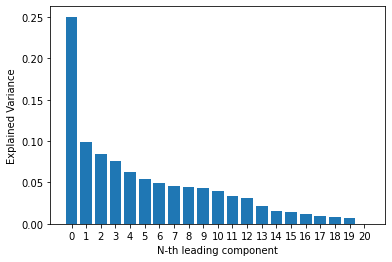

In [ ]:
#Plot explained variance per number of leading PC's 
plt.bar(np.arange(21).astype(str), eigenvalues) 
plt.xlabel("N-th leading component")
plt.ylabel("Explained Variance")
plt.show()

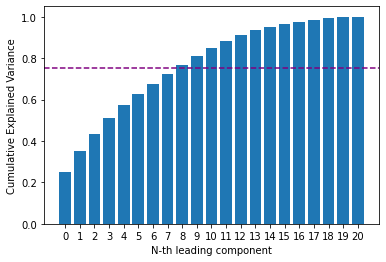

In [ ]:
stack_e = [np.sum(eigenvalues[:i]) for i in range(1, 22)]
np.array(stack_e).reshape(21,)
plt.bar(np.arange(21).astype(str), stack_e) 
plt.axhline(y=0.75, color='purple', linestyle='--')
plt.xlabel("N-th leading component")
plt.ylabel("Cumulative Explained Variance")
plt.show()

<BarContainer object of 21 artists>

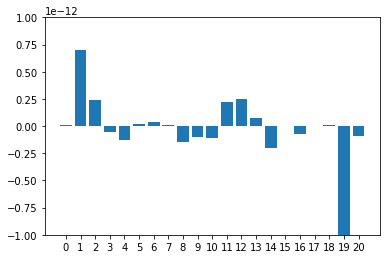

In [ ]:
# plt.figure(figsize=(10,8))
plt.bar(np.arange(21).astype(str),pca.mean_*1000, 0.8)

In [ ]:
values_std.shape

(6221, 21)

## KMeans Clustering 

K-Means: [Inertia](https://www.codecademy.com/learn/machine-learning/modules/dspath-clustering/cheatsheet)
Inertia measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster.

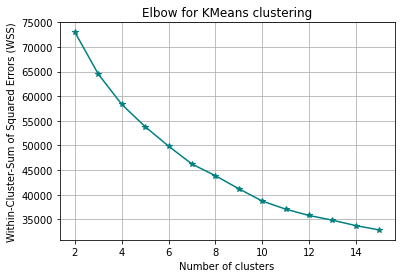

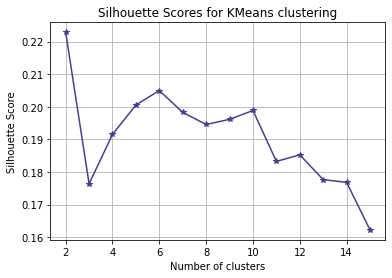

In [ ]:
def calculate_indicators(attributes, kmax):
  K = []
  sse = []
  silhouette_scores = [] 

  for k in range(2, kmax+1):
    K.append(k)
    kmeans = KMeans(n_clusters = k, random_state=1234).fit(attributes)
    # sse
    sse.append(kmeans.inertia_)
    # silhouette scores
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(attributes, labels, metric = 'euclidean'))
    
  # elbow curve
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.plot(K, sse, 'b*-', color='teal')
  plt.grid(True)
  plt.xlabel('Number of clusters')
  plt.ylabel('Within-Cluster-Sum of Squared Errors (WSS)')
  plt.title('Elbow for KMeans clustering')
  plt.show()
  
  # silhouette score curve
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.plot(K, silhouette_scores, 'b*-', color='darkslateblue')
  plt.grid(True)
  plt.xlabel('Number of clusters')
  plt.ylabel("Silhouette Score")
  plt.title('Silhouette Scores for KMeans clustering')
  plt.show()
  # return sse, silhouette_scores

calculate_indicators(pca_features[:, :8], 15)

#### Try model K=4

In [ ]:
kmeans_4 = KMeans(n_clusters = 4, random_state=1234).fit(pca_features[:, :8])
clusters = kmeans_4.predict(pca_features[:, :8])
clusters

array([2, 2, 2, ..., 0, 0, 0], dtype=int32)

In [ ]:
df['Cluster'] = clusters
df.head()

,Median Esimated Visitor Count,Total Population,Percent Male,Median Age,Percent Two races excluding Some other race and three or more races,Percent White alone,Percent Black or African American alone,Percent American Indian and Alaska Native alone,Percent Native Hawaiian and Other Pacific Islander alone,Percent Some other race alone,Percent Two or more races,Percent Asian alone & Two races including Some other race,Total Households,Percent Households with one or more people under 18 years,Percent Households with one or more people 60 years and over,Percent over 25 without a high school diploma,Percent over 25 with a bachelor’s degree or higher,Percent Households Income in the past 12 months below poverty level,Median Household Income,Percent Household received Food Stamps/SNAP,Percent Households received Food Stamps/SNAP have disability,Percent Employed,Percent Civilian labor force,Cluster
census_block_group,,,,,,,,,,,,,,,,,,,,,,,,
360050001001,226.924590,6864,0.924388,35.0,0.015006,0.325321,0.557110,0.002622,0.0,0.073572,0.015006,0.026369,0,NaN,NaN,0.515975,0.014873,NaN,NaN,NaN,NaN,NaN,0.000000,2
360050002001,15.659303,1744,0.444381,40.2,0.014908,0.460436,0.331422,0.000000,0.0,0.193234,0.014908,0.000000,460,0.423913,0.541304,0.246892,0.277975,0.326087,41968.0,0.334783,0.357143,0.762500,0.366972,2
360050002002,7.781848,1569,0.527725,28.9,0.013384,0.368388,0.291906,0.000000,0.0,0.281071,0.058636,0.045252,477,0.421384,0.425577,0.243154,0.303395,0.144654,48523.0,0.190776,0.637363,0.860104,0.369025,2
360050002003,9.376958,1219,0.484003,42.2,0.043478,0.441345,0.274815,0.000000,0.0,0.178835,0.043478,0.061526,405,0.407407,0.585185,0.137892,0.306054,0.024691,68060.0,0.108642,1.000000,0.985940,0.466776,3
360050004001,6.738028,598,0.548495,40.3,0.000000,0.707358,0.065217,0.000000,0.0,0.215719,0.000000,0.011706,262,0.213740,0.492366,0.174731,0.206989,0.312977,NaN,0.095420,0.000000,1.000000,0.605351,3


In [ ]:
df.shape

(6221, 24)

In [ ]:
df.to_csv('/content/drive/MyDrive/SafeGraph/Data/cbg_attr_and_cluster.csv', index=True)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/SafeGraph/Data/cbg_attr_and_cluster_1021.csv').set_index('census_block_group')
df.head()

,Median Esimated Visitor Count,Total Population,Percent Male,Median Age,Percent Two races excluding Some other race and three or more races,Percent White alone,Percent Black or African American alone,Percent American Indian and Alaska Native alone,Percent Native Hawaiian and Other Pacific Islander alone,Percent Some other race alone,Percent Two or more races,Percent Asian alone & Two races including Some other race,Total Households,Percent Households with one or more people under 18 years,Percent Households with one or more people 60 years and over,Percent over 25 without a high school diploma,Percent over 25 with a bachelor’s degree or higher,Percent Households Income in the past 12 months below poverty level,Median Household Income,Percent Household received Food Stamps/SNAP,Percent Households received Food Stamps/SNAP have disability,Percent Employed,Percent Civilian labor force,Cluster
census_block_group,,,,,,,,,,,,,,,,,,,,,,,,
360050001001,226.924590,6864,0.924388,35.0,0.015006,0.325321,0.557110,0.002622,0.0,0.073572,0.015006,0.026369,0,NaN,NaN,0.515975,0.014873,NaN,NaN,NaN,NaN,NaN,0.000000,2
360050002001,15.659303,1744,0.444381,40.2,0.014908,0.460436,0.331422,0.000000,0.0,0.193234,0.014908,0.000000,460,0.423913,0.541304,0.246892,0.277975,0.326087,41968.0,0.334783,0.357143,0.762500,0.366972,2
360050002002,7.781848,1569,0.527725,28.9,0.013384,0.368388,0.291906,0.000000,0.0,0.281071,0.058636,0.045252,477,0.421384,0.425577,0.243154,0.303395,0.144654,48523.0,0.190776,0.637363,0.860104,0.369025,2
360050002003,9.376958,1219,0.484003,42.2,0.043478,0.441345,0.274815,0.000000,0.0,0.178835,0.043478,0.061526,405,0.407407,0.585185,0.137892,0.306054,0.024691,68060.0,0.108642,1.000000,0.985940,0.466776,3
360050004001,6.738028,598,0.548495,40.3,0.000000,0.707358,0.065217,0.000000,0.0,0.215719,0.000000,0.011706,262,0.213740,0.492366,0.174731,0.206989,0.312977,NaN,0.095420,0.000000,1.000000,0.605351,3


In [ ]:
cluster_cbg = df[['Cluster']].reset_index()
cluster_cbg.census_block_group = cluster_cbg.census_block_group.astype('str')
# cluster_cbg.census_block_group = cluster_cbg.census_block_group.astype('int64')
cluster_cbg.head()

,census_block_group,Cluster
0,360050001001,2
1,360050002001,2
2,360050002002,2
3,360050002003,3
4,360050004001,3


In [ ]:
cluster_cbg.shape

(6221, 2)

In [ ]:
cbg = gpd.read_file('/content/drive/MyDrive/SafeGraph/Data/nyc_cbgs.geojson')
cluster_geo = cluster_cbg.merge(cbg, left_on='census_block_group', right_on='CensusBlockGroup', how='outer')
cluster_geo = gpd.GeoDataFrame(cluster_geo)

In [ ]:
# cluster_geo.to_csv('/content/drive/MyDrive/SafeGraph/Data/cbg_cluster_geo.csv', index=False)

In [ ]:
# function for visualizing communities 
from matplotlib.lines import Line2D 

def visualizePartitionShape(gdf, label, field_id, K, plttitle=''):
    
    fig, ax =  plt.subplots(figsize=(15, 15))
    cbg.boundary.plot(color='grey', alpha=0.1, ax=ax)
    colors=['pink','gold','teal','darkslateblue','tab:blue','tab:red','skyblue','tab:purple','gray','brown','seagreen','wheat']

    for c in range(K): # for each cluster
        gdf.geometry.loc[gdf[label]==c].plot(color=colors[c], ax=ax)
    
    count_cbg = gdf[[label, field_id]].groupby(label).count()
    legend_elements = [Line2D([0], [0], color='w', marker='o', label='Cluster %d: %d'%(i, count_cbg.census_block_group[i]), markersize=18, markerfacecolor=colors[i]) for i in range(K)]

    ax.set_axis_off()
    ax.legend(handles=legend_elements, title='Clusters & CBG num', title_fontsize=15, loc='upper left', fontsize=14, frameon=False, prop={'weight':'bold'}) #
    # plt.title(plttitle) 
    plt.show()

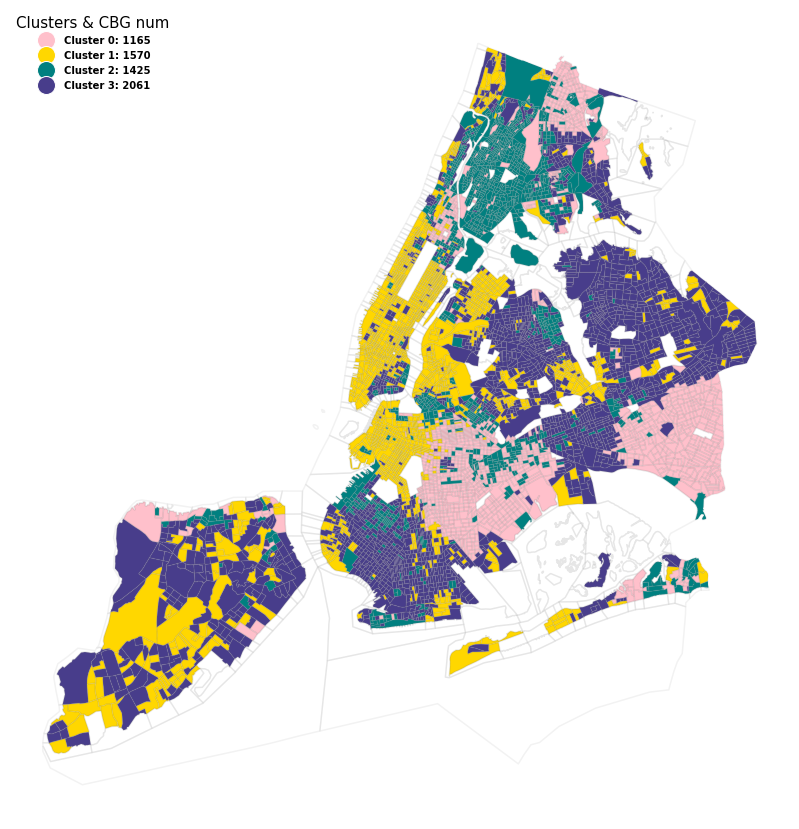

In [ ]:
visualizePartitionShape(cluster_geo, 'Cluster', 'census_block_group', 4)

In [ ]:
median_col = ['Cluster', 'Median Esimated Visitor Count', 'Total Population',
              'Median Age', 'Total Households', 'Median Household Income']
census_cluster = df[median_col].groupby('Cluster').median()
census_cluster

,Median Esimated Visitor Count,Total Population,Median Age,Total Households,Median Household Income
Cluster,,,,,
0,9.497089,1198.0,37.7,413.0,65489.0
1,12.472960,1154.5,37.5,528.5,109115.0
2,10.126920,1371.0,32.0,454.0,33398.0
3,10.396356,1265.0,40.8,430.0,67750.0


In [ ]:
# recalculate attributes 
    # population: cbg_pct * cbg_pop / total_cluster_pop
    # households: cbg_pct * cbg_hhd / total_cluster_hhd 

def pct_calculator(df, df_columns, denominator):
    df_pct = df[df_columns+['Cluster', denominator]]
    for i in df_columns:
      df_pct[i] = df_pct[i]*df_pct[denominator]
    for i in df.Cluster.unique():
      df_pct = df_pct.groupby('Cluster').sum()
    for i in df_columns:
      df_pct[i] = df_pct[i]/df_pct[denominator]
    df_pct = df_pct.drop(denominator, axis=1)
    return df_pct

In [ ]:
pop_col =['Percent Male',
          'Percent over 25 without a high school diploma',
          'Percent over 25 with a bachelor’s degree or higher',
          'Percent Employed', 'Percent Civilian labor force']
pop_attr = pct_calculator(df, pop_col, 'Total Population')

hhd_col = ['Percent Households with one or more people under 18 years',
           'Percent Households with one or more people 60 years and over',
           'Percent Households Income in the past 12 months below poverty level',
           'Percent Household received Food Stamps/SNAP',
           'Percent Households received Food Stamps/SNAP have disability']
hhd_attr = pct_calculator(df, hhd_col, 'Total Households')

In [ ]:
rc_col = ['Percent Two races excluding Some other race and three or more races',
      'Percent White alone', 'Percent Black or African American alone',
      'Percent American Indian and Alaska Native alone',
      'Percent Native Hawaiian and Other Pacific Islander alone',
      'Percent Some other race alone', 'Percent Two or more races',
      'Percent Asian alone & Two races including Some other race']
rc = pct_calculator(df, rc_col, 'Total Population')
rc

,Percent Two races excluding Some other race and three or more races,Percent White alone,Percent Black or African American alone,Percent American Indian and Alaska Native alone,Percent Native Hawaiian and Other Pacific Islander alone,Percent Some other race alone,Percent Two or more races,Percent Asian alone & Two races including Some other race
Cluster,,,,,,,,
0,0.019056,0.134697,0.714224,0.002726,0.000808,0.083877,0.027040,0.044613
1,0.033743,0.741327,0.062633,0.001988,0.000322,0.038488,0.040166,0.121498
2,0.025946,0.250015,0.306270,0.007922,0.000849,0.336345,0.041813,0.072653
3,0.022446,0.495090,0.066729,0.004098,0.000407,0.117442,0.034481,0.293787


In [ ]:
sum_rc = np.sum(rc, axis=1)
for i in rc.columns:
  rc[i] = rc[i]/sum_rc
rc

,Percent Two races excluding Some other race and three or more races,Percent White alone,Percent Black or African American alone,Percent American Indian and Alaska Native alone,Percent Native Hawaiian and Other Pacific Islander alone,Percent Some other race alone,Percent Two or more races,Percent Asian alone & Two races including Some other race
Cluster,,,,,,,,
0,0.018554,0.131150,0.695419,0.002654,0.000787,0.081668,0.026328,0.043439
1,0.032440,0.712701,0.060215,0.001911,0.000309,0.037002,0.038615,0.116806
2,0.024905,0.239980,0.293978,0.007604,0.000815,0.322845,0.040135,0.069737
3,0.021698,0.478588,0.064504,0.003962,0.000394,0.113528,0.033332,0.283995


In [ ]:
np.sum(rc, axis=1)

Cluster
0    1.0
1    1.0
2    1.0
3    1.0
dtype: float64

In [ ]:
census_cluster = pd.concat([census_cluster, pop_attr, hhd_attr, rc], axis=1)
census_cluster

,Median Esimated Visitor Count,Total Population,Median Age,Total Households,Median Household Income,Percent Male,Percent over 25 without a high school diploma,Percent over 25 with a bachelor’s degree or higher,Percent Employed,Percent Civilian labor force,Percent Households with one or more people under 18 years,Percent Households with one or more people 60 years and over,Percent Households Income in the past 12 months below poverty level,Percent Household received Food Stamps/SNAP,Percent Households received Food Stamps/SNAP have disability,Percent Two races excluding Some other race and three or more races,Percent White alone,Percent Black or African American alone,Percent American Indian and Alaska Native alone,Percent Native Hawaiian and Other Pacific Islander alone,Percent Some other race alone,Percent Two or more races,Percent Asian alone & Two races including Some other race
Cluster,,,,,,,,,,,,,,,,,,,,,,,
0,9.497089,1198.0,37.7,413.0,65489.0,0.453672,0.144060,0.285168,0.929661,0.528342,0.313761,0.404563,0.152268,0.185170,0.400631,0.018554,0.131150,0.695419,0.002654,0.000787,0.081668,0.026328,0.043439
1,12.472960,1154.5,37.5,528.5,109115.0,0.483336,0.052567,0.691913,0.960757,0.627920,0.189844,0.305183,0.082069,0.046929,0.273876,0.032440,0.712701,0.060215,0.001911,0.000309,0.037002,0.038615,0.116806
2,10.126920,1371.0,32.0,454.0,33398.0,0.471574,0.330433,0.154100,0.886874,0.430960,0.391388,0.351019,0.364198,0.450567,0.445208,0.024905,0.239980,0.293978,0.007604,0.000815,0.322845,0.040135,0.069737
3,10.396356,1265.0,40.8,430.0,67750.0,0.489378,0.191654,0.330113,0.948991,0.497537,0.291240,0.464315,0.147702,0.155210,0.500564,0.021698,0.478588,0.064504,0.003962,0.000394,0.113528,0.033332,0.283995


In [ ]:
census_cluster.shape

(4, 23)

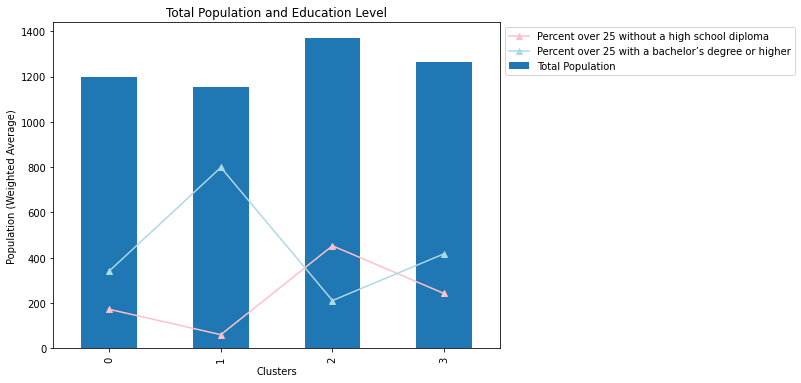

In [ ]:
plt.figure(figsize=(8,6))
census_cluster['Total Population'].plot.bar(label='Total Population')
# plt.plot(census_cluster['Total Households'], 'b*-', color='gold', label='Total Households')
plt.plot(census_cluster['Percent over 25 without a high school diploma']*census_cluster['Total Population'], 'b^-', color='pink', label='Percent over 25 without a high school diploma')
plt.plot(census_cluster['Percent over 25 with a bachelor’s degree or higher']*census_cluster['Total Population'], 'b^-', color='lightblue', label='Percent over 25 with a bachelor’s degree or higher')
plt.title('Total Population and Education Level')
plt.ylabel('Population (Weighted Average)')
plt.xlabel('Clusters')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

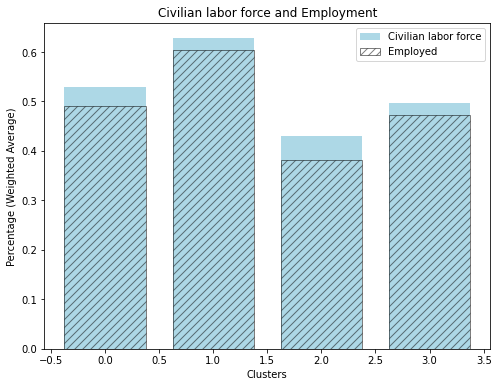

In [ ]:
plt.figure(figsize=(8,6))
plt.bar(census_cluster.index, census_cluster['Percent Civilian labor force'], 0.75, color='lightblue', label='Civilian labor force')
plt.bar(census_cluster.index, census_cluster['Percent Civilian labor force']*census_cluster['Percent Employed'], 0.75, color='darkblue', alpha=0.5, fill=False, hatch='///', label='Employed')
plt.title('Civilian labor force and Employment')
plt.ylabel('Percentage (Weighted Average)')
plt.xlabel('Clusters')
plt.legend()

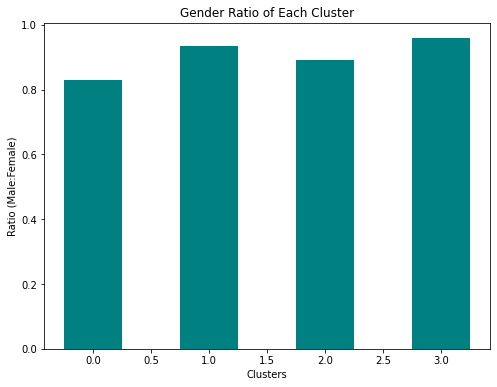

In [ ]:
ratio = list(census_cluster['Percent Male']/(1-census_cluster['Percent Male']))
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(census_cluster.index, ratio, 0.5,  label='Gender Ratio', color='teal')
ax.set_ylabel('Ratio (Male:Female)')
ax.set_xlabel('Clusters')
ax.set_title('Gender Ratio of Each Cluster')
# ax.set_yticks(np.arange(0, 1.1, 0.1))
# ax.legend()
plt.show()

Text(0.5, 0, 'Clusters')

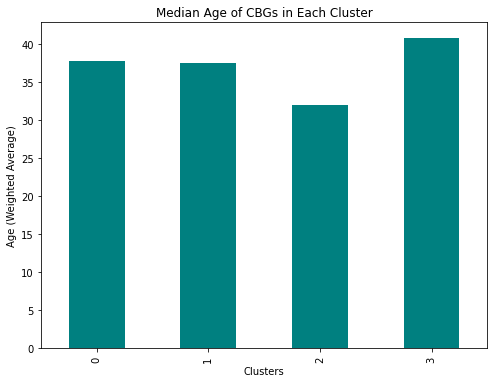

In [ ]:
plt.figure(figsize=(8,6))
census_cluster['Median Age'].plot.bar(color='teal')
plt.title('Median Age of CBGs in Each Cluster')
plt.ylabel('Age (Weighted Average)')
plt.xlabel('Clusters')

Text(0.5, 0, 'Clusters')

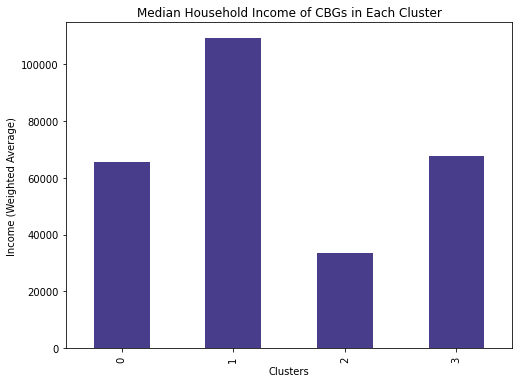

In [ ]:
plt.figure(figsize=(8,6))
census_cluster['Median Household Income'].plot.bar(color='darkslateblue')
plt.title('Median Household Income of CBGs in Each Cluster')
plt.ylabel('Income (Weighted Average)')
plt.xlabel('Clusters')

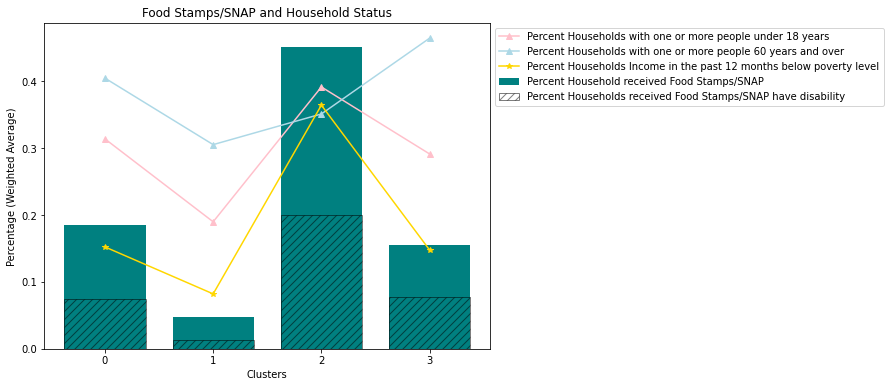

In [ ]:
plt.figure(figsize=(8,6))
plt.bar(census_cluster.index, census_cluster['Percent Household received Food Stamps/SNAP'], 0.75, color='teal', label='Percent Household received Food Stamps/SNAP')
plt.bar(census_cluster.index, census_cluster['Percent Households received Food Stamps/SNAP have disability']*census_cluster['Percent Household received Food Stamps/SNAP'], 0.75, color='lightgrey', alpha=0.5, fill=False, hatch='///', label='Percent Households received Food Stamps/SNAP have disability')
plt.plot(census_cluster['Percent Households with one or more people under 18 years'], 'b^-', color='pink', label='Percent Households with one or more people under 18 years')
plt.plot(census_cluster['Percent Households with one or more people 60 years and over'], 'b^-', color='lightblue', label='Percent Households with one or more people 60 years and over')
plt.plot(census_cluster['Percent Households Income in the past 12 months below poverty level'], 'b*-', color='gold', label='Percent Households Income in the past 12 months below poverty level')
plt.title('Food Stamps/SNAP and Household Status')
plt.ylabel('Percentage (Weighted Average)')
plt.xlabel('Clusters')
plt.xticks(range(4))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

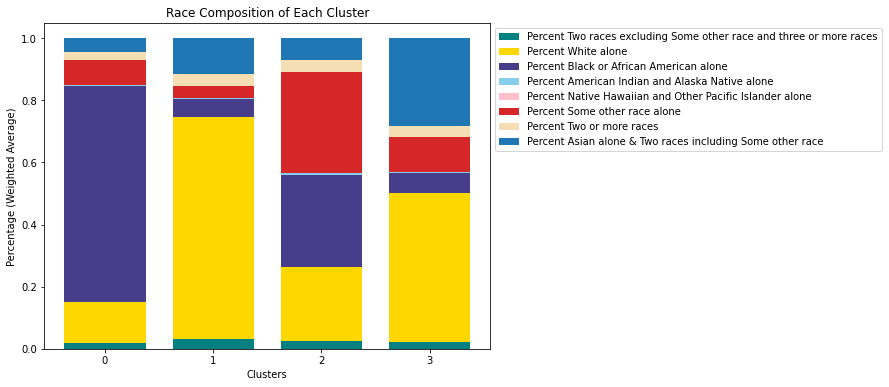

In [ ]:
plt.figure(figsize=(8,6))
colors=['teal','gold','darkslateblue','skyblue','pink','tab:red','wheat','tab:blue','tab:purple','gray','brown','seagreen']
for i in range(rc.shape[1]):
  if i == 0:
    plt.bar(rc.index, rc.iloc[:, i], width=0.75, color=colors[i], label=rc.columns[i])
  else:
    plt.bar(rc.index, rc.iloc[:, i], 
        bottom=np.sum(rc.iloc[:, :i], axis=1), width=0.75, color=colors[i], label=rc.columns[i])
    
plt.xticks(rc.index)
# plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel("Clusters")
plt.ylabel('Percentage (Weighted Average)')
plt.title('Race Composition of Each Cluster')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Text(0.5, 1.0, 'Visitor Count of Each Cluster')

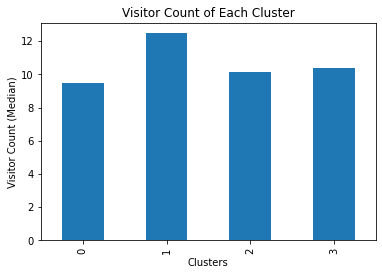

In [ ]:
census_cluster['Median Esimated Visitor Count'].plot.bar()
plt.xlabel("Clusters")
plt.ylabel('Visitor Count (Median)')
plt.title('Visitor Count of Each Cluster')